In [97]:
# !pip install tensorflow_model_optimization

In [98]:
# !pip install --upgrade --force-reinstall tensorflow

In [99]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets, optimizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import tensorflow.keras.backend as K
import os
import csv
import datetime
import json
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Create log directory
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f"training_logs_{timestamp}"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(os.path.join(log_dir, "graphs"), exist_ok=True)
os.makedirs(os.path.join(log_dir, "metrics"), exist_ok=True)
os.makedirs(os.path.join(log_dir, "models"), exist_ok=True)

# Logger class for all outputs
class Logger:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.metrics_file = os.path.join(log_dir, "metrics", "training_metrics.csv")
        self.summary_file = os.path.join(log_dir, "experiment_summary.txt")

        # Initialize metrics file with headers
        with open(self.metrics_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Timestamp','Model','FLOPS','Iteration', 'Accuracy', 'Loss'])

        # Initialize summary file
        with open(self.summary_file, 'w') as f:
            f.write(f"Experiment started at: {datetime.datetime.now()}\n")
            f.write(f"Log directory: {os.path.abspath(log_dir)}\n\n")

    def log_metrics(self, model_name,FLOPS,iteration, accuracy, loss):
        """Log metrics to CSV file"""
        with open(self.metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([datetime.datetime.now(), model_name,FLOPS,iteration, accuracy, loss])

    def log_text(self, text):
        """Log text to summary file"""
        with open(self.summary_file, 'a') as f:
            f.write(f"{text}\n")

    def save_figure(self, fig, filename):
        """Save matplotlib figure to graphs directory"""
        filepath = os.path.join(self.log_dir, "graphs", filename)
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        return filepath

    def save_model(self, model, model_name, iteration=None):
        """Save model to models directory"""
        model_name = model_name.replace(" ", "_")
        if iteration is not None:
            model_path = os.path.join(self.log_dir, "models", f"{model_name}_iter_{iteration}.h5")
        else:
            model_path = os.path.join(self.log_dir, "models", f"{model_name}.h5")

        model.save(model_path)
        return model_path

    def save_model_summary(self, model, model_name):
        """Save model summary to text file"""
        summary_path = os.path.join(self.log_dir, "models", f"{model_name}_summary.txt")

        # Capture model summary
        model_summary = []
        model.summary(print_fn=lambda x: model_summary.append(x))

        with open(summary_path, 'w') as f:
            f.write('\n'.join(model_summary))

        return summary_path

    def save_json(self, data, filename):
        """Save dictionary as JSON file"""
        filepath = os.path.join(self.log_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=4)
        return filepath

# Initialize the logger
logger = Logger(log_dir)

# Log hyperparameters
hyperparams = {
    "batch_size": 128,
    "learning_rate": 0.001,
    "num_classes": 10,
    "initial_sample_size": 2000,
    "budget_per_iteration": 6000,
    "iterations": 5,
    "num_epochs": 20,
    "prune_ratio": 0.02
}
logger.save_json(hyperparams, "hyperparameters.json")

# Original Hyperparameters
batch_size = hyperparams["batch_size"]
learning_rate = hyperparams["learning_rate"]
num_classes = hyperparams["num_classes"]
initial_sample_size = hyperparams["initial_sample_size"]
budget_per_iteration = hyperparams["budget_per_iteration"]
iterations = hyperparams["iterations"]
num_epochs = hyperparams["num_epochs"]
prune_ratio = hyperparams["prune_ratio"]

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)



# Define LeNet5 Model


# FLOP Counter
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model, input_shape=(1, 32, 32, 3)):
    """
    Calculates the total FLOPs for a TensorFlow model using a dummy input.

    Args:
        model (tf.keras.Model): The model to analyze.
        input_shape (tuple): Shape of one input sample. Default is (1, 32, 32, 3) for CIFAR-10.

    Returns:
        int: Total number of floating point operations (FLOPs).
    """
    @tf.function
    def model_forward(x):
        return model(x)

    dummy_input = tf.random.normal(input_shape)
    concrete_func = model_forward.get_concrete_function(dummy_input)

    profile_opts = ProfileOptionBuilder.float_operation()
    flops_result = profile(concrete_func.graph, options=profile_opts)

    return flops_result.total_float_ops

In [100]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_filter_history(filter_history, model_name):
#     # Convert list of dicts to DataFrame
#     df = pd.DataFrame(filter_history)
#     df['Iteration'] = range(1, len(df) + 1)

#     # Melt for line plot
#     df_melt = df.melt(id_vars='Iteration', var_name='Layer', value_name='Filters')

#     # Line plot
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=df_melt, x='Iteration', y='Filters', hue='Layer', marker='o')

#     plt.title(f"🔧 Filters Per Layer Over Iterations ({model_name})")
#     plt.xlabel("Iteration")
#     plt.ylabel("Number of Filters")
#     plt.grid(True)
#     plt.legend(title="Layer", bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()

#     # Save the figure
#     fig = plt.gcf()
#     filename = f"{model_name}_filter_history_lineplot.png"
#     logger.save_figure(fig, filename)
#     plt.show()


In [101]:
import tensorflow as tf
from tensorflow.keras import layers, models , optimizers

def create_lenet5():
    # Using Functional API for more control over layers
    inputs = layers.Input(shape=(32, 32, 3))  # Explicit InputLayer
    x = inputs

    x = layers.Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(16, kernel_size=(5, 5), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(84, activation='relu')(x)
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)  # Define the model with inputs and outputs

    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [102]:
import numpy as np
def structured_prune_model(model, prune_ratio, learning_rate=0.001):
    """
    Prune convolutional filters in a CNN model based on their L1 norm.

    Args:
        model: The original Keras model to prune
        prune_ratio: Float between 0 and 1, the fraction of filters to prune
        learning_rate: Learning rate for the optimizer when recompiling

    Returns:
        A new pruned model with reduced number of filters

    """
    msg = (
    f"\n=== Structured Pruning Model Initiated ===\n"
    f" Pruning Ratio: {prune_ratio*100:.2f}%\n"
    + "─" * 80
    )
    print(msg)
    logger.log_text(msg)
    # Get input shape from the original model
    original_input_shape = model.input_shape[1:]

    # Extract layer configurations and weights
    layer_configs = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            layer_configs.append({
                'type': layer.__class__,
                'config': layer.get_config(),
                'weights': layer.get_weights(),
                'name': layer.name
            })
        else:
            layer_configs.append({
                'type': layer.__class__,
                'config': layer.get_config(),
                'weights': None if len(layer.get_weights()) == 0 else layer.get_weights(),
                'name': layer.name
            })

    # Analyze filters to prune using L1-norm
    pruned_filters = {}
    input_channels_map = {}

    # First pass: Determine which filters to prune in each layer
    for i, layer_config in enumerate(layer_configs):
        if layer_config['type'] == layers.Conv2D:
            weights = layer_config['weights'][0]  # Shape: [h, w, in_channels, out_channels]

            # Calculate L1 norm for each filter
            filter_norms = np.sum(np.abs(weights), axis=(0, 1, 2))

            # Sort filters by L1 norm
            sorted_indices = np.argsort(filter_norms)

            # Calculate how many filters to keep
            num_filters = weights.shape[3]
            num_to_keep = max(1, int(num_filters * (1 - prune_ratio)))

            # Get indices of filters to keep (highest L1 norm)
            keep_indices = sorted_indices[-num_to_keep:]
            keep_indices = np.sort(keep_indices)  # Sort to maintain order

            # Store which filters to keep for this layer
            pruned_filters[i] = keep_indices

            # Track dependencies for next layers that use these outputs as inputs
            for j in range(i+1, len(layer_configs)):
                # Find the next Conv2D layer
                if layer_configs[j]['type'] == layers.Conv2D:
                    input_channels_map[j] = keep_indices
                    break

    # Build new model with pruned architecture
    inputs = layers.Input(shape=original_input_shape)
    x = inputs

    # Dictionary to keep track of layer outputs
    layer_outputs = {-1: x}  # Start with input layer

    # Flag to track if we need to recalculate Dense layer weights
    need_recalculation = False

    # Build the pruned model
    for i, layer_config in enumerate(layer_configs):
        if layer_config['type'] == layers.Conv2D:
            config = layer_config['config'].copy()
            weights = layer_config['weights']

            # Get indices of filters to keep for this layer
            if i in pruned_filters:
                keep_filters = pruned_filters[i]
            else:
                keep_filters = np.arange(weights[0].shape[3])

            # Prune output filters
            w_filters = weights[0][:, :, :, keep_filters]
            bias = weights[1][keep_filters] if len(weights) > 1 else None

            # Update filters in config
            config['filters'] = len(keep_filters)

            # If input channels were pruned, adjust weights accordingly
            if i in input_channels_map:
                input_indices = input_channels_map[i]
                w_filters = w_filters[:, :, input_indices, :]
                need_recalculation = True  # We've pruned filters, so Dense layers might need adjustment

            # Create new layer with pruned config
            new_layer = layers.Conv2D.from_config(config)
            x = new_layer(x)
            layer_outputs[i] = x

            # Set pruned weights
            if bias is not None:
                new_layer.set_weights([w_filters, bias])
            else:
                new_layer.set_weights([w_filters])

        elif layer_config['type'] == layers.Dense:
            config = layer_config['config'].copy()
            weights = layer_config['weights']

            # Create the dense layer with original config
            new_layer = layers.Dense.from_config(config)

            # If previous layers have been pruned and this is the first Dense layer after Flatten
            if need_recalculation and i > 0:
                # We need to get the current shape after pruning
                prev_output_shape = layer_outputs[i-1].shape[1:]

                if isinstance(layer_configs[i-1]['type'], layers.Flatten.__class__):
                    # If the previous layer is Flatten, we need to create weights with the new flattened size
                    flattened_size = np.prod(prev_output_shape)
                    output_size = weights[0].shape[1]

                    # Create new random weights matching the required shape
                    # In practice, you might want to initialize these more carefully
                    new_weights = [
                        np.random.randn(int(flattened_size), output_size) * 0.01,
                        np.zeros(output_size) if len(weights) > 1 else None
                    ]

                    # Apply the new layer
                    x = new_layer(x)
                    layer_outputs[i] = x

                    # Set the new weights (only if bias exists)
                    if len(weights) > 1:
                        new_layer.set_weights([new_weights[0], weights[1]])
                    else:
                        new_layer.set_weights([new_weights[0]])

                else:
                    # Apply the layer with original weights if previous layer wasn't Flatten
                    x = new_layer(x)
                    layer_outputs[i] = x
                    new_layer.set_weights(weights)
            else:
                # No pruning affected this layer's input
                x = new_layer(x)
                layer_outputs[i] = x
                if weights is not None:
                    new_layer.set_weights(weights)

        elif layer_config['type'] == layers.MaxPooling2D:
            config = layer_config['config'].copy()
            new_layer = layers.MaxPooling2D.from_config(config)
            x = new_layer(x)
            layer_outputs[i] = x

        elif layer_config['type'] == layers.Dropout:
            config = layer_config['config'].copy()
            new_layer = layers.Dropout.from_config(config)
            x = new_layer(x)
            layer_outputs[i] = x

        else:
            # For any other layer types, try to recreate them from their configs
            try:
                config = layer_config['config'].copy()
                new_layer = layer_config['type'].from_config(config)
                x = new_layer(x)
                layer_outputs[i] = x

                if layer_config['weights'] is not None:
                    new_layer.set_weights(layer_config['weights'])
            except Exception as e:
                print(f"Warning: Could not recreate layer of type {layer_config['type']}: {e}")

    # Create the final model
    pruned_model = models.Model(inputs=inputs, outputs=x, name=f"pruned_{model.name}")

    msg2 = (
    "\n=== Structured Pruning Model Completed Successfully ===\n"
    + "─" * 80
    )
    print(msg2)
    logger.log_text(msg2)

    return pruned_model,pruned_filters,input_channels_map


In [103]:
import numpy as np
def reintalize_prune_model(model,kept_filters_map,input_channels,learning_rate=0.001):

    msg = (
    "\n=== Reinitalizing Pruned Model weights===\n"
    + "─" * 80
    )
    print(msg)
    logger.log_text(msg)

    # Get input shape from the original model
    original_input_shape = model.input_shape[1:]
    # Extract layer configurations and weights
    layer_configs = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            layer_configs.append({
                'type': layer.__class__,
                'config': layer.get_config(),
                'weights': layer.get_weights(),
                'name': layer.name
            })
        else:
            layer_configs.append({
                'type': layer.__class__,
                'config': layer.get_config(),
                'weights': None if len(layer.get_weights()) == 0 else layer.get_weights(),
                'name': layer.name
            })



    # Analyze filters to prune using L1-norm
    pruned_filters = kept_filters_map

    input_channels_map = input_channels

    # Build new model with pruned architecture
    inputs = layers.Input(shape=original_input_shape)
    x = inputs

    # Dictionary to keep track of layer outputs
    layer_outputs = {-1: x}  # Start with input layer

    # Flag to track if we need to recalculate Dense layer weights
    need_recalculation = False

    # Build the pruned model
    for i, layer_config in enumerate(layer_configs):
        if layer_config['type'] == layers.Conv2D:
            config = layer_config['config'].copy()
            weights = layer_config['weights']

            # Get indices of filters to keep for this layer
            if i in pruned_filters:
                keep_filters = pruned_filters[i]
            else:
                keep_filters = np.arange(weights[0].shape[3])

            # Prune output filters
            w_filters = weights[0][:, :, :, keep_filters]
            bias = weights[1][keep_filters] if len(weights) > 1 else None

            # Update filters in config
            config['filters'] = len(keep_filters)

            # If input channels were pruned, adjust weights accordingly
            if i in input_channels_map:
                input_indices = input_channels_map[i]
                w_filters = w_filters[:, :, input_indices, :]
                need_recalculation = True  # We've pruned filters, so Dense layers might need adjustment

            # Create new layer with pruned config
            new_layer = layers.Conv2D.from_config(config)
            x = new_layer(x)
            layer_outputs[i] = x

            # Set pruned weights
            if bias is not None:
                new_layer.set_weights([w_filters, bias])
            else:
                new_layer.set_weights([w_filters])

        elif layer_config['type'] == layers.Dense:
            config = layer_config['config'].copy()
            weights = layer_config['weights']

            # Create the dense layer with original config
            new_layer = layers.Dense.from_config(config)

            # If previous layers have been pruned and this is the first Dense layer after Flatten
            if need_recalculation and i > 0:
                # We need to get the current shape after pruning
                prev_output_shape = layer_outputs[i-1].shape[1:]

                if isinstance(layer_configs[i-1]['type'], layers.Flatten.__class__):
                    # If the previous layer is Flatten, we need to create weights with the new flattened size
                    flattened_size = np.prod(prev_output_shape)
                    output_size = weights[0].shape[1]

                    # Create new random weights matching the required shape
                    # In practice, you might want to initialize these more carefully
                    new_weights = [
                        np.random.randn(int(flattened_size), output_size) * 0.01,
                        np.zeros(output_size) if len(weights) > 1 else None
                    ]

                    # Apply the new layer
                    x = new_layer(x)
                    layer_outputs[i] = x

                    # Set the new weights (only if bias exists)
                    if len(weights) > 1:
                        new_layer.set_weights([new_weights[0], weights[1]])
                    else:
                        new_layer.set_weights([new_weights[0]])

                else:
                    # Apply the layer with original weights if previous layer wasn't Flatten
                    x = new_layer(x)
                    layer_outputs[i] = x
                    new_layer.set_weights(weights)
            else:
                # No pruning affected this layer's input
                x = new_layer(x)
                layer_outputs[i] = x
                if weights is not None:
                    new_layer.set_weights(weights)

        elif layer_config['type'] == layers.MaxPooling2D:
            config = layer_config['config'].copy()
            new_layer = layers.MaxPooling2D.from_config(config)
            x = new_layer(x)
            layer_outputs[i] = x

        elif layer_config['type'] == layers.Dropout:
            config = layer_config['config'].copy()
            new_layer = layers.Dropout.from_config(config)
            x = new_layer(x)
            layer_outputs[i] = x

        else:
            # For any other layer types, try to recreate them from their configs
            try:
                config = layer_config['config'].copy()
                new_layer = layer_config['type'].from_config(config)
                x = new_layer(x)
                layer_outputs[i] = x

                if layer_config['weights'] is not None:
                    new_layer.set_weights(layer_config['weights'])
            except Exception as e:
                print(f"Warning: Could not recreate layer of type {layer_config['type']}: {e}")

    # Create the final model
    pruned_model = models.Model(inputs=inputs, outputs=x, name=f"pruned_{model.name}")


    return pruned_model



In [104]:
def plot_accuracy_history(accuracy_list, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(accuracy_list)+1), accuracy_list, marker='o', linestyle='-', color='blue')
    plt.title(f" Test Accuracy Over Iterations ({model_name})")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()

    fig = plt.gcf()
    filename = f"{model_name}_accuracy_history.png"
    logger.save_figure(fig, filename)
    plt.show()


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_filter_history(filter_history, model_name):
    # Convert to DataFrame
    df = pd.DataFrame(filter_history)

    # Melt the DataFrame so that each row is one (iteration, layer, filter count)
    df_melt = df.reset_index().melt(id_vars='index', var_name='Layer', value_name='Filters')
    df_melt.rename(columns={'index': 'Iteration'}, inplace=True)

    # Set custom labels for layers (assuming Conv1 is layer 0, Conv2 is layer 1)
    df_melt['Layer'] = df_melt['Layer'].replace({0: 'Conv1', 1: 'Conv2'})

    # Plot: Iteration vs Filters, grouped by Layer with custom blue/red colors
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Iteration', y='Filters', hue='Layer', data=df_melt, palette=['blue', 'red'])

    # Add count labels on top of each bar
    for p in plt.gca().patches:
        # Adding filter count label
        plt.gca().annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=10, color='black', fontweight='bold',
            xytext=(0, 5), textcoords='offset points'
        )

    # Set plot title and labels
    plt.title(f"📊 Filter Count per Iteration by Layer ({model_name})")
    plt.xlabel("Iteration")
    plt.ylabel("Number of Filters")

    # Fixing legend to ensure correct order and color (blue is Conv1, red is Conv2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=[handles[0], handles[1]], labels=["Conv1", "Conv2"], title="Layer", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()

    # Save the figure using logger
    fig = plt.gcf()
    filename = f"{model_name}_filter_count_per_iteration.png"
    logger.save_figure(fig, filename)

    # Show the plot
    plt.show()


In [106]:
def plot_loss_history(loss_list, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(loss_list)+1), loss_list, marker='s', linestyle='--', color='red')
    plt.title(f"📉 Test Loss Over Iterations ({model_name})")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()

    fig = plt.gcf()
    filename = f"{model_name}_loss_history.png"
    logger.save_figure(fig, filename)
    plt.show()


In [107]:
# def get_prune_ratio(n,prune_ratio=prune_ratio):
#     n=n+1
#     return prune_ratio ** (1 / n)


In [108]:
# Modified active learning function with logging
def active_learning_cycle(model, x_labeled, y_labeled, x_unlabeled, y_unlabeled, model_name):
    accuracy_list = []
    loss_list = []
    iteration_history = []
    filter_history = []

    for i in range(iterations):

        msg = f"\n📚 Model: {model_name} | 🔁 Iteration {i+1}/{iterations} | 🧪 Training on {len(x_labeled)} samples\n" + "-" * 80
        print(msg)
        logger.log_text(msg)

        model.summary()

        # Create a callback to save history
        class HistoryCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                if logs is not None:
                    for key, value in logs.items():
                        logger.log_text(f"Epoch {epoch+1} - {key}: {value:.4f}")

        # Train the model

        # Use standard training
        history = model.fit(
            x_labeled, y_labeled,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[HistoryCallback()]
        )

        # Save history for this iteration
        iteration_history.append(history.history)

        # Save model at last iteration
        if i == iterations - 1:
           logger.save_model(model, f"{model_name} Sub Network", iteration=i+1)

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        accuracy_list.append(test_acc)
        loss_list.append(test_loss)

        flops = get_flops(model)
        # Log metrics
        logger.log_metrics(model_name,flops,i+1, test_acc, test_loss)

        # print(f"{model_name} - Test Accuracy after iteration {i+1}: {test_acc:.4f}, Loss: {test_loss:.4f}\n")
        # logger.log_text(f"{model_name} - Test Accuracy after iteration {i+1}: {test_acc:.4f}, Loss: {test_loss:.4f}\n")
        msg2 = (
            f"\n=== {model_name} - Test Results (Iteration {i+1}) ===\n"
            f"Accuracy: {test_acc:.4f}\n"
            f"Loss:     {test_loss:.4f}\n"
            + "-" * 80
        )
        print(msg2)
        logger.log_text(msg2)
        # Uncertainty-based sampling
        if i < iterations - 1:  # Skip sampling on the last iteration
            # Calculate uncertainty of unlabeled samples
            predictions = model.predict(x_unlabeled, verbose=0)
            uncertainties = 1 - np.max(predictions, axis=1)  # Least confidence

            # Select most uncertain samples
            uncertain_indices = np.argsort(uncertainties)[-budget_per_iteration:]

            # Move selected samples to labeled set
            new_labeled_x = x_unlabeled[uncertain_indices]
            new_labeled_y = y_unlabeled[uncertain_indices]

            x_labeled = np.vstack((x_labeled, new_labeled_x))
            y_labeled = np.vstack((y_labeled, new_labeled_y))

            # Remove selected samples from unlabeled set
            mask = np.ones(len(x_unlabeled), dtype=bool)
            mask[uncertain_indices] = False
            x_unlabeled = x_unlabeled[mask]
            y_unlabeled = y_unlabeled[mask]

            logger.log_text(f"Added {len(new_labeled_x)} samples to labeled set.")
            logger.log_text(f"Labeled set size: {len(x_labeled)}")
            logger.log_text(f"Unlabeled set size: {len(x_unlabeled)}")

        prune_ratio_2=get_prune_ratio(i)
        model, kept_filters_map ,input_channels_map = structured_prune_model(model, prune_ratio_2)

        filter_counts = {}
        for layer_name, indices in kept_filters_map.items():
            # Count the number of kept filters for this layer
            filter_counts[layer_name] = len(indices)

        msg_filter = (
            f"\n=== {model_name} - Filter Counts After Pruning (Iteration {i+1}) ===\n"
            f"{filter_counts}\n"
            + "-" * 80
        )
        print(msg_filter)
        logger.log_text(msg_filter)
        filter_history.append(filter_counts)


        model = reintalize_prune_model(cloned_base_model, kept_filters_map,input_channels_map,learning_rate=0.001)
        model.compile(
            optimizer=optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )



    # Save entire training history
    logger.save_json({
        "accuracy_history": accuracy_list,
        "loss_history": loss_list,
        "training_history": iteration_history,
        "filter_history": filter_history
    }, f"metrics/{model_name}_training_history.json")

    return accuracy_list, loss_list,filter_history,model


In [109]:
# Modified evaluation and reporting function
def evaluate_and_report(model, x_test, y_test, model_name, num_classes=10):
    # Get predictions
    y_pred_prob = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Log metrics
    evaluation_results = []
    evaluation_results.append(f"\n{model_name} - Classification Report:")
    evaluation_results.append(f"Accuracy: {accuracy:.4f}")
    evaluation_results.append(f"Precision: {precision:.4f}")
    evaluation_results.append(f"Recall: {recall:.4f}")
    evaluation_results.append(f"F1-Score: {f1:.4f}")

    # AUC and ROC Curve
    y_test_bin = label_binarize(y_true, classes=list(range(num_classes)))
    auc_score = roc_auc_score(y_test_bin, y_pred_prob, average='weighted', multi_class='ovr')
    evaluation_results.append(f"AUC Score: {auc_score:.4f}")

    # Print and log evaluation results
    for line in evaluation_results:
        print(line)
        logger.log_text(line)

    # Save evaluation metrics to JSON
    eval_metrics = {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "auc_score": float(auc_score)
    }
    logger.save_json(eval_metrics, f"metrics/{model_name}_evaluation_metrics.json")

    # Plot and save ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC: {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    logger.save_figure(plt, f"{model_name}_roc_curve.png")
    plt.close()

    # Plot and save Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    logger.save_figure(plt, f"{model_name}_confusion_matrix.png")
    plt.close()

    # Save confusion matrix data
    logger.save_json({"confusion_matrix": cm.tolist()}, f"metrics/{model_name}_confusion_matrix.json")

    return eval_metrics

Starting LeNet-5 structured pruning experiment...
Logging to directory: /content/training_logs_20250414_035751
Creating base LeNet-5 model...



LeNet5 Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,126 (324.71 KB)

 Trainable params: 83,126 (324.71 KB)

 Non-trainable params: 0 (0.00 B)


Starting active learning cycle for LeNet model...

📚 Model: LeNet5 | 🔁 Iteration 1/5 | 🧪 Training on 2000 samples
--------------------------------------------------------------------------------


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,126 (324.71 KB)

 Trainable params: 83,126 (324.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.1225 - loss: 2.3063 - val_accuracy: 0.2098 - val_loss: 2.2550
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2316 - loss: 2.2055 - val_accuracy: 0.2390 - val_loss: 2.0694
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2779 - loss: 2.0170 - val_accuracy: 0.2682 - val_loss: 1.9765
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2942 - loss: 1.9311 - val_accuracy: 0.3305 - val_loss: 1.9050
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3336 - loss: 1.8591 - val_accuracy: 0.3279 - val_loss: 1.8705
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3710 - loss: 1.7446 - val_accuracy: 0.3734 - val_loss: 1.7874
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3968 - loss: 1.7059 - val_accuracy: 0.3647 - val_loss: 1.7751
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4224 - loss: 1.5987 - val_accuracy: 0.3657 - 

Model: "pruned_functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 5)      │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 15)     │         1,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 540)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        64,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,204 (305.48 KB)

 Trainable params: 78,204 (305.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.1257 - loss: 2.2893 - val_accuracy: 0.1661 - val_loss: 2.2326
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1591 - loss: 2.1907 - val_accuracy: 0.1537 - val_loss: 2.1153
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1891 - loss: 2.1097 - val_accuracy: 0.1858 - val_loss: 1.9743
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1900 - loss: 2.0611 - val_accuracy: 0.1946 - val_loss: 1.9432
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1934 - loss: 2.0374 - val_accuracy: 0.2222 - val_loss: 1.9051
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1981 - loss: 2.0153 - val_accuracy: 0.2625 - val_loss: 1.8534
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2339 - loss: 1.9634 - val_accuracy: 0.2959 - val_loss: 1.7923
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2333 - loss: 1.9335 - val_accuracy: 0.3083 - val_lo

Model: "pruned_functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 4)      │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 12)     │         1,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 432)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        51,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,490 (251.91 KB)

 Trainable params: 64,490 (251.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.1452 - loss: 2.2635 - val_accuracy: 0.1644 - val_loss: 2.1985
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1652 - loss: 2.1432 - val_accuracy: 0.1896 - val_loss: 1.9889
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1722 - loss: 2.0878 - val_accuracy: 0.2249 - val_loss: 1.9389
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1905 - loss: 2.0448 - val_accuracy: 0.2488 - val_loss: 1.8749
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1994 - loss: 2.0082 - val_accuracy: 0.2646 - val_loss: 1.8284
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2288 - loss: 1.9631 - val_accuracy: 0.2893 - val_loss: 1.8150
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2418 - loss: 1.9392 - val_accuracy: 0.2898 - val_loss: 1.7516
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2422 - loss: 1.9379 - val_accuracy: 0

Model: "pruned_functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 2)      │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 8)      │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        34,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,254 (180.68 KB)

 Trainable params: 46,254 (180.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1389 - loss: 2.2687 - val_accuracy: 0.1291 - val_loss: 2.3097
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1634 - loss: 2.1895 - val_accuracy: 0.1823 - val_loss: 2.0765
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1751 - loss: 2.1383 - val_accuracy: 0.2056 - val_loss: 2.0234
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2004 - loss: 2.0998 - val_accuracy: 0.2531 - val_loss: 1.9418
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2117 - loss: 2.0457 - val_accuracy: 0.2895 - val_loss: 1.8714
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2357 - loss: 1.9991 - val_accuracy: 0.3155 - val_loss: 1.8095
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2528 - loss: 1.9585 - val_accuracy: 0.3417 - val_loss: 1.7323
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2706 - loss: 1.9155 - val_accuracy: 0

Model: "pruned_functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 1)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,594 (111.70 KB)

 Trainable params: 28,594 (111.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1315 - loss: 2.2683 - val_accuracy: 0.1401 - val_loss: 2.2577
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1513 - loss: 2.2183 - val_accuracy: 0.1459 - val_loss: 2.2358
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1643 - loss: 2.1761 - val_accuracy: 0.2026 - val_loss: 2.1060
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1834 - loss: 2.1302 - val_accuracy: 0.2032 - val_loss: 2.0637
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1893 - loss: 2.1063 - val_accuracy: 0.2475 - val_loss: 2.0196
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2025 - loss: 2.0914 - val_accuracy: 0.2463 - val_loss: 2.0282
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2185 - loss: 2.0620 - val_accuracy: 0.2802 - val_loss: 1.9444
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2229 - loss: 2.0415 - val_accuracy: 0


=== LeNet5 - Test Results (Iteration 5) ===
Accuracy: 0.3981
Loss:     1.6470
--------------------------------------------------------------------------------

=== Structured Pruning Model Initiated ===
 Pruning Ratio: 45.73%
────────────────────────────────────────────────────────────────────────────────

=== Structured Pruning Model Completed Successfully ===
────────────────────────────────────────────────────────────────────────────────

=== LeNet5 - Filter Counts After Pruning (Iteration 5) ===
{1: 1, 3: 2}
--------------------------------------------------------------------------------

=== Reinitalizing Pruned Model weights===
────────────────────────────────────────────────────────────────────────────────


<ipython-input-105-7d8f0a44958a>:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-99-f253f9d7a5ed>:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.savefig(filepath, dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


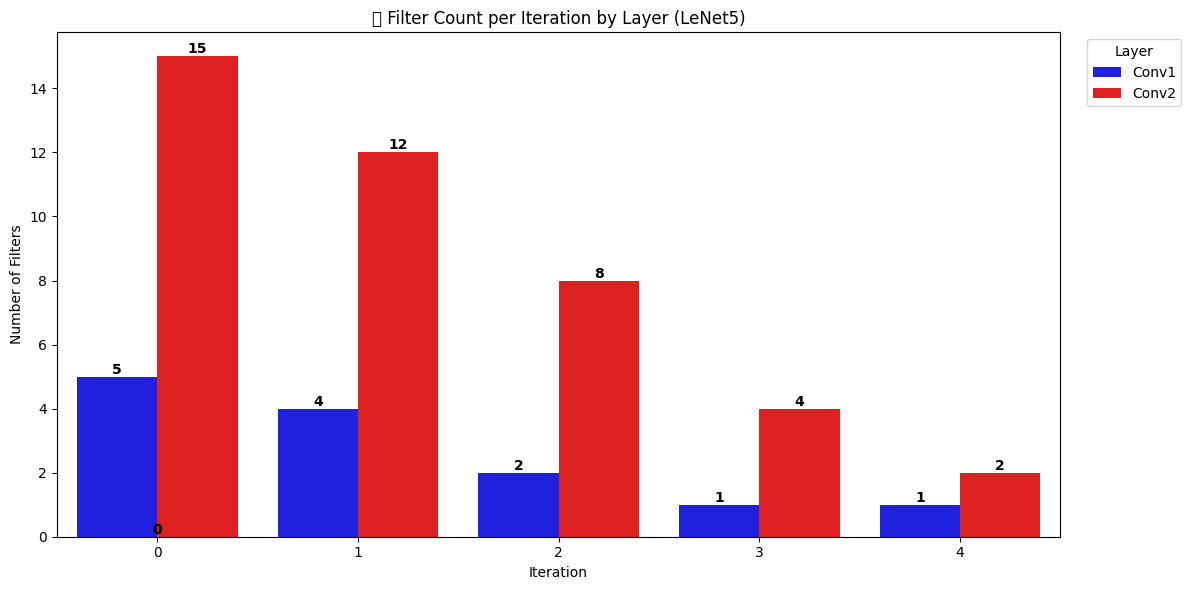

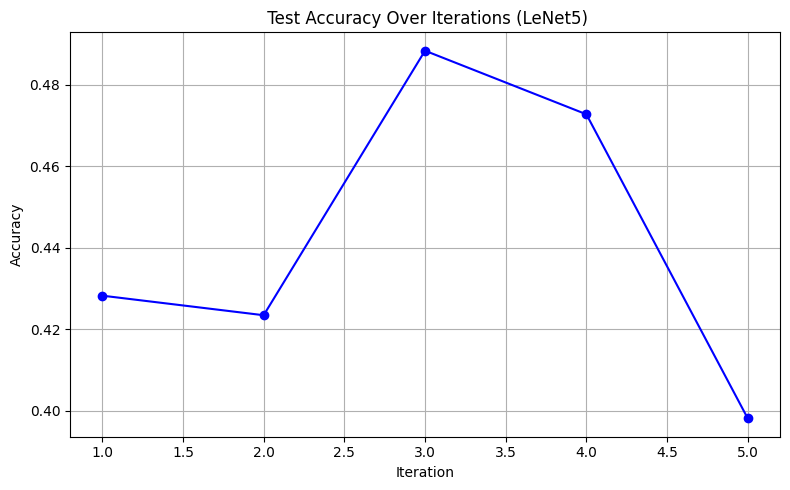

<ipython-input-106-643cb948318f>:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-99-f253f9d7a5ed>:55: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.savefig(filepath, dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


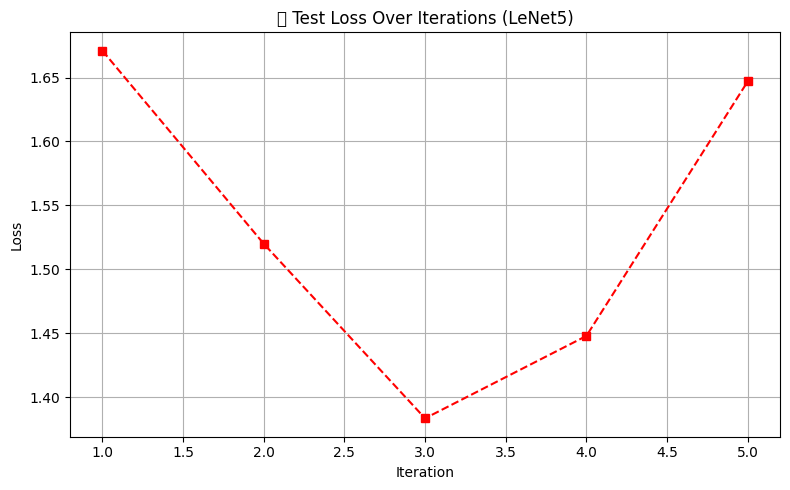

Final orginal model summary:



LeNet5 Model Summary:


Model: "pruned_functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_60 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 1)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 2)      │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │         8,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,902 (77.74 KB)

 Trainable params: 19,902 (77.74 KB)

 Non-trainable params: 0 (0.00 B)


Final evaluation of original model:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Original Model - Classification Report:
Accuracy: 0.0910
Precision: 0.0254
Recall: 0.0910
F1-Score: 0.0260
AUC Score: 0.5434


{'accuracy': 0.091,
 'precision': 0.02544520080661311,
 'recall': 0.091,
 'f1_score': 0.026045547325262607,
 'auc_score': 0.5433993944444444}

In [110]:

logger.log_text("Starting LeNet-5 structured pruning experiment...")
print("Starting LeNet-5 structured pruning experiment...")
print(f"Logging to directory: {os.path.abspath(log_dir)}")

# Create initial labeled and unlabeled datasets
indices = np.random.permutation(len(x_train))
initial_indices = indices[:initial_sample_size]
remaining_indices = indices[initial_sample_size:]

x_labeled = x_train[initial_indices]
y_labeled = y_train[initial_indices]
x_unlabeled = x_train[remaining_indices]
y_unlabeled = y_train[remaining_indices]

# Create and compile original model
print("Creating base LeNet-5 model...")
logger.log_text("Creating base LeNet-5 model...")
base_model = create_lenet5()

cloned_base_model = tf.keras.models.clone_model(base_model)
# Step 2: Copy the weights of the original model into the cloned model
cloned_base_model.set_weights(base_model.get_weights())

# Save original model summary
logger.save_model_summary(base_model, "LeNet5")
print("\nLeNet5 Model Summary:")
base_model.summary()


# Active Learning for base Model
print("\nStarting active learning cycle for LeNet model...")
acc_history, loss_history,filter_history,final_sub_network = active_learning_cycle(
    base_model, x_labeled, y_labeled, x_unlabeled, y_unlabeled, "LeNet5"
)

plot_filter_history(filter_history,"LeNet5")
plot_accuracy_history(acc_history, "LeNet5")
plot_loss_history(loss_history, "LeNet5")

print("Final orginal model summary:")
# Save original model summary
logger.save_model_summary(final_sub_network, "LeNet5_SubNetwork")
print("\nLeNet5 Model Summary:")
final_sub_network.summary()


print("\nFinal evaluation of original model:")
evaluate_and_report(final_sub_network, x_test, y_test, "Original Model")




<ipython-input-105-7d8f0a44958a>:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-99-f253f9d7a5ed>:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.savefig(filepath, dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


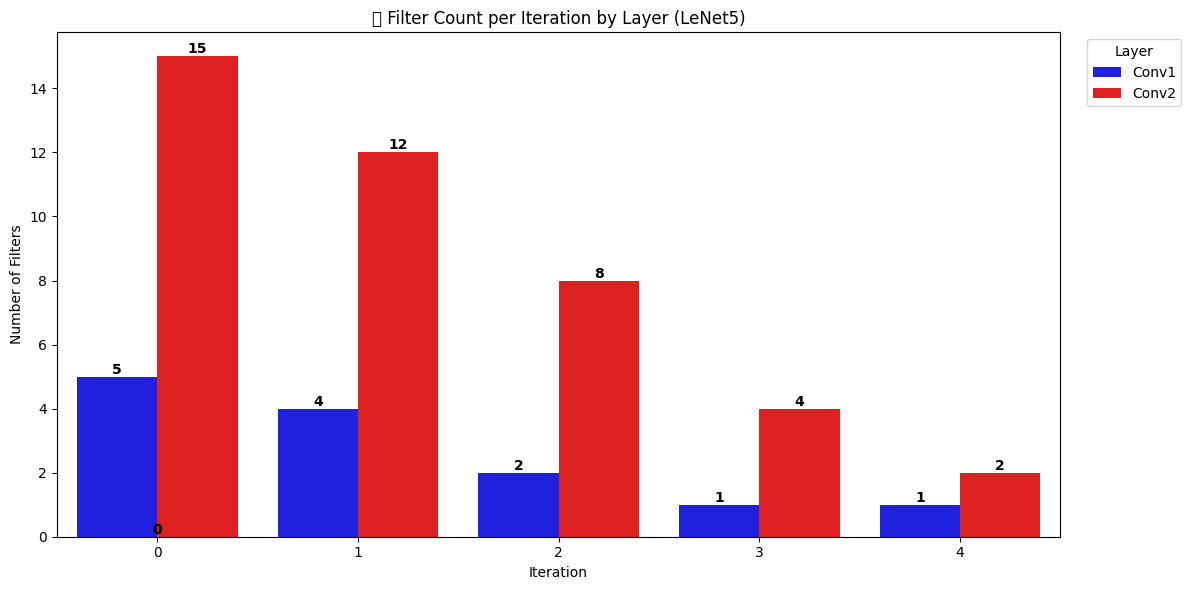

In [111]:
plot_filter_history(filter_history,"LeNet5")

In [112]:
final_sub_network_clone = tf.keras.models.clone_model(final_sub_network)
final_sub_network_clone.set_weights(final_sub_network.get_weights())

cloned_model_2 = tf.keras.models.clone_model(cloned_base_model)
cloned_model_2.set_weights(cloned_base_model.get_weights())

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3100 - loss: 1.8850 - val_accuracy: 0.4662 - val_loss: 1.4764
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4836 - loss: 1.4461 - val_accuracy: 0.5090 - val_loss: 1.3529
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5335 - loss: 1.3062 - val_accuracy: 0.5620 - val_loss: 1.2430
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5783 - loss: 1.1890 - val_accuracy: 0.5838 - val_loss: 1.1761
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5985 - loss: 1.1221 - val_accuracy: 0.6200 - val_loss: 1.1084
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6353 - loss: 1.0348 - val_accuracy: 0.6224 - val_loss: 1.0843
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6517 - loss: 0.9905 - val_accuracy: 0.6202 - val_loss: 1.0992
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6668 - loss: 0.9452 - val_accuracy: 0.

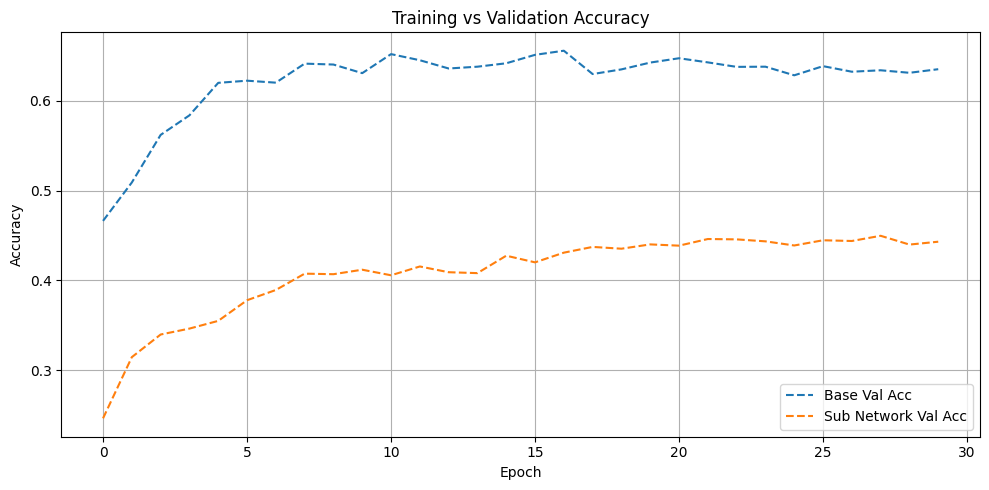

In [113]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# --- 1. Load and preprocess CIFAR-10 ---
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# --- 2. Compile both models ---
cloned_model_2.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

final_sub_network_clone.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# --- 3. Train both models ---
history_base = cloned_model_2.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

history_sub_netowrk= final_sub_network_clone.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# --- 4. Evaluate both models ---
base_loss, base_acc = cloned_model_2.evaluate(x_test, y_test, verbose=0)
sub_network_loss, sub_network_acc = final_sub_network_clone.evaluate(x_test, y_test, verbose=0)

print(f"\n🔍 Evaluation on CIFAR-10 Test Set:")
print(f"Original Model - Accuracy: {base_acc:.4f}, Loss: {base_loss:.4f}")
print(f"Pruned Model   - Accuracy: {sub_network_acc:.4f}, Loss: {sub_network_loss:.4f}")

# --- 5. Compare model sizes ---
orig_params = cloned_model_2.count_params()
pruned_params = final_sub_network_clone.count_params()

print(f"\n📦 Model Size (Total Parameters):")
print(f"Original Model: {orig_params}")
print(f"Pruned Model:   {pruned_params}")

# --- 6. Plot Accuracy Curve ---
plt.figure(figsize=(10, 5))
# plt.plot(history_base.history['accuracy'], label='Original Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Base Val Acc', linestyle='--')

# plt.plot(history_pruned.history['accuracy'], label='Pruned Train Acc')
plt.plot(history_sub_netowrk.history['val_accuracy'], label='Sub Network Val Acc', linestyle='--')

plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [114]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# get_flops(cloned_model)

In [ ]:
# get_flops(final_original_model)

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [115]:
import shutil

src_path = '/content/training_logs_20250413_235838'
dst_path = '/content/drive/My Drive/Colab Notebooks/training_logs_20250413_235838'

# Use shutil.copytree() to copy the directory
shutil.copytree(src_path, dst_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/training_logs_20250413_235838'

In [ ]:
import pandas as pd

# If uploaded directly:
df = pd.read_csv('/content/training_logs_20250413_235838/metrics/training_metrics.csv')  # replace with the actual file name

# Or if from Google Drive:
# df = pd.read_csv(file_path)

# Show first few rows
df.head()


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)